# CAP 6615 Neural Networks Programming Assignment 4 – CNN && RNN

### Keyuan Lu, Wenxuan Bao, Yiming Xu, Yufan Chen, Yue Bai

In [1]:
import numpy as np
import os
import random 
from datetime import datetime
from numpy import genfromtxt
import pandas as pd
import torch
import torch.nn as nn
from torch.autograd import Variable
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

## Step 1 - Design and build a dataset for CNN && RNN model

### Select S&P500 Dataset and Schiller P/E ratio. Make an overlay of the Schiller P/E from 1 Jan 1960 to 31 Dec 2020, onto the S&P500 for the same period.

In [2]:
# Read s&p500 price data and schiller pe data.
# Note that 'HistoricalPrices.csv' only includes data after 1978
# Therefore, we use two datasets for s&p500 price ('HistoricalPrices.csv' and 'HistoricalPrices_old.csv' ), 
# and will combine them later
price_new=pd.read_csv('HistoricalPrices.csv')
price_old=pd.read_csv('HistoricalPrices_old.csv')
pe=pd.read_csv('ie_data_PE_full.csv')

In [3]:
# Note that the P/E ratio is monthly data 
pe=pe.rename({'Date':'Date_PE'},axis=1)
pe

,Date_PE,PE_CAPE
0,1960.01,18.338285
1,1960.02,17.545275
2,1960.03,17.286021
3,1960.04,17.429767
4,1960.05,17.256171
...,...,...
727,2020.08,31.152309
728,2020.09,30.833593
729,2020.10,31.277783
730,2020.11,32.471647


In [4]:
# remove redundant variables
price_old = price_old.drop(['Volume', 'Adj Close' ], 1)
# transform Date to date timestamp
price_old['Date'] = pd.to_datetime(price_old['Date'])
price_old = price_old.loc[ (price_old['Date'] < '1978-01-03') &  (price_old['Date']  >= '1960-01-01' )]
price_old

,Date,Open,High,Low,Close
2511,1960-01-04,59.910000,59.910000,59.910000,59.910000
2512,1960-01-05,60.389999,60.389999,60.389999,60.389999
2513,1960-01-06,60.130001,60.130001,60.130001,60.130001
2514,1960-01-07,59.689999,59.689999,59.689999,59.689999
2515,1960-01-08,59.500000,59.500000,59.500000,59.500000
...,...,...,...,...,...
7016,1977-12-23,93.800003,94.989998,93.750000,94.690002
7017,1977-12-27,94.690002,95.209999,94.089996,94.690002
7018,1977-12-28,94.690002,95.199997,93.989998,94.750000
7019,1977-12-29,94.750000,95.430000,94.099998,94.940002


In [5]:
price_new['Date'] = pd.to_datetime(price_new['Date'])
#reverse the dataset
price_new = price_new.iloc[::-1].reset_index(drop = True)
#reset the column names
price_new. columns = ['Date', 'Open', 'High', 'Low', 'Close']
price_new

,Date,Open,High,Low,Close
0,1978-01-03,93.82,95.15,93.49,93.82
1,1978-01-04,93.52,94.10,93.16,93.52
2,1978-01-05,92.74,94.53,92.51,92.74
3,1978-01-06,91.62,92.66,91.05,91.62
4,1978-01-09,90.64,91.52,90.01,90.64
...,...,...,...,...,...
10839,2020-12-24,3694.03,3703.82,3689.32,3703.06
10840,2020-12-28,3723.03,3740.51,3723.03,3735.36
10841,2020-12-29,3750.01,3756.12,3723.31,3727.04
10842,2020-12-30,3736.19,3744.63,3730.21,3732.04


In [6]:
# combine two s&p500 datasets
# now the dataset includes all the s&p 500 price data from 1 Jan 1960 to 31 Dec 2020  
frames = [price_old, price_new]
price = pd.concat(frames).reset_index(drop = True)
price

,Date,Open,High,Low,Close
0,1960-01-04,59.910000,59.910000,59.910000,59.910000
1,1960-01-05,60.389999,60.389999,60.389999,60.389999
2,1960-01-06,60.130001,60.130001,60.130001,60.130001
3,1960-01-07,59.689999,59.689999,59.689999,59.689999
4,1960-01-08,59.500000,59.500000,59.500000,59.500000
...,...,...,...,...,...
15349,2020-12-24,3694.030000,3703.820000,3689.320000,3703.060000
15350,2020-12-28,3723.030000,3740.510000,3723.030000,3735.360000
15351,2020-12-29,3750.010000,3756.120000,3723.310000,3727.040000
15352,2020-12-30,3736.190000,3744.630000,3730.210000,3732.040000


In [7]:
price['Date_PE']=0.0
for i in range(price.shape[0]):
    month = price['Date'][i].month
    year = price['Date'][i].year
    price.loc[i, 'Date_PE']=year+month*0.01
# merge sp500 data with the Schiller P/E ratio based on Date.
data_full = pd.merge(price, pe, how='left', on='Date_PE')
data_full = data_full.drop(['Date_PE' ], 1)

In [8]:
# save the merged dataset
data_full.to_csv('Price_PE.csv')

In [9]:
data_full

,Date,Open,High,Low,Close,PE_CAPE
0,1960-01-04,59.910000,59.910000,59.910000,59.910000,18.338285
1,1960-01-05,60.389999,60.389999,60.389999,60.389999,18.338285
2,1960-01-06,60.130001,60.130001,60.130001,60.130001,18.338285
3,1960-01-07,59.689999,59.689999,59.689999,59.689999,18.338285
4,1960-01-08,59.500000,59.500000,59.500000,59.500000,18.338285
...,...,...,...,...,...,...
15349,2020-12-24,3694.030000,3703.820000,3689.320000,3703.060000,33.769789
15350,2020-12-28,3723.030000,3740.510000,3723.030000,3735.360000,33.769789
15351,2020-12-29,3750.010000,3756.120000,3723.310000,3727.040000,33.769789
15352,2020-12-30,3736.190000,3744.630000,3730.210000,3732.040000,33.769789


### Make an overlay of the Schiller P/E onto the S&P500 for the same period.

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


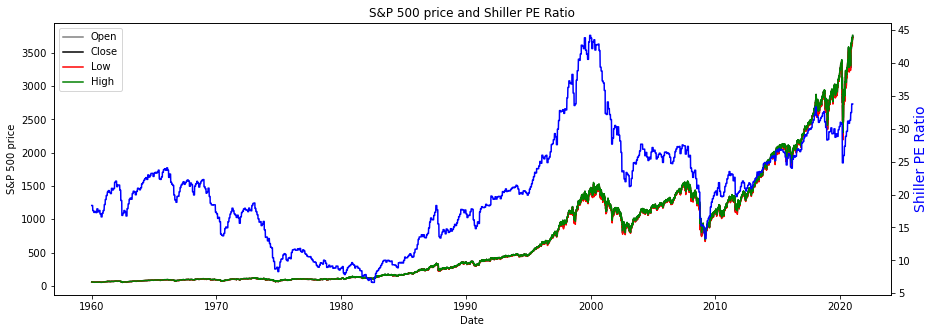

In [10]:
plt.figure(figsize=(15, 5));
plt.plot(data_full.Date, data_full.Open.values, color='grey', label='Open')
plt.plot(data_full.Date, data_full.Close.values, color='black', label='Close')
plt.plot(data_full.Date, data_full.Low.values, color='red', label='Low')
plt.plot(data_full.Date, data_full.High.values, color='green', label='High')
plt.title('S&P 500 price and Shiller PE Ratio')
plt.xlabel('Date')
plt.ylabel('S&P 500 price')
plt.legend(loc='best')
# twin object for two different y-axis on the sample plot
ax2=plt.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(data_full.Date, data_full.PE_CAPE.values,color="blue")
ax2.set_ylabel("Shiller PE Ratio", color="blue",fontsize=14)
plt.savefig('price_pe.eps')
plt.show()


#### Here, we are only using ClOSE price and Cyclicily adjusted PE-ratio to train the model

In [11]:
dataset = data_full[ ['Close', 'PE_CAPE']].values
dataset

array([[  59.91      ,   18.33828499],
       [  60.389999  ,   18.33828499],
       [  60.130001  ,   18.33828499],
       ...,
       [3727.04      ,   33.76978942],
       [3732.04      ,   33.76978942],
       [3756.07      ,   33.76978942]])

## From Schiller P/E report analysis, we use PE ratio to "hint" about the RNN according to its price state and add this as a new data column
### refer https://www.longtermtrends.net/sp500-price-earnings-shiller-pe-ratio/

In [12]:
# '-0.5' indicates stocks are extremely undervalued
# '-0.5-(-0.25)' indicates stocks are undervalued
# '-0.25-0' indicates stocks are fair
# '0-0.25' indicates stocks are overvalued
# '0.25-0.5' indicates stocks are in a bubble
# '0.5' indicates stocks are in an extreme bubble
def checkPEState(pe_ratio):
    state = 0
    if pe_ratio < 7.5:
        state = -0.5
    elif pe_ratio >= 7.5 and pe_ratio < 12.75:
        state = -0.5 + (pe_ratio-7.5)/(12.75-7.5) * 0.25
    elif pe_ratio >= 12.75 and pe_ratio < 15:
        state = -0.25 + (pe_ratio-12.75)/(15-12.75) * 0.25
    elif pe_ratio >= 15 and pe_ratio < 20:
        state = 0 + (pe_ratio-15)/5 * 0.25
    elif pe_ratio >= 20 and pe_ratio < 25:
        state = 0.25 + (pe_ratio-20)/5 * 0.25
    elif pe_ratio >= 25:
        state = 0.5
    return state

In [13]:
# Adding the PEState as additional feature
dataset = np.append(dataset,np.zeros([len(dataset),1]),1)
for x in dataset:
    s = checkPEState(x[1])
    x[2] = s
dataset

array([[5.99100000e+01, 1.83382850e+01, 1.66914249e-01],
       [6.03899990e+01, 1.83382850e+01, 1.66914249e-01],
       [6.01300010e+01, 1.83382850e+01, 1.66914249e-01],
       ...,
       [3.72704000e+03, 3.37697894e+01, 5.00000000e-01],
       [3.73204000e+03, 3.37697894e+01, 5.00000000e-01],
       [3.75607000e+03, 3.37697894e+01, 5.00000000e-01]])

In [14]:
# extract the timestamp data
date_data= data_full[ ['Date']].values

In [15]:
# Feature Scaling: min-max normalization of features
sc = MinMaxScaler(feature_range = (0, 1))
dataset_scaled = sc.fit_transform(dataset)
dataset_scaled

array([[0.00208161, 0.31149771, 0.66691425],
       [0.0022112 , 0.31149771, 0.66691425],
       [0.002141  , 0.31149771, 0.66691425],
       ...,
       [0.99216225, 0.72235494, 1.        ],
       [0.99351219, 0.72235494, 1.        ],
       [1.        , 0.72235494, 1.        ]])

In [16]:
# number of timepoint and number of feature
n_rows, n_cols = dataset_scaled.shape
(n_rows, n_cols)

(15354, 3)

In [17]:
# general settings
# The number of expected features in the input x is 3
input_size = 3
# output_size = 4 as we want to predict the next one, two, three, and four trading data 
output_size = 4
# sequence length is 180
window_size = 180

In [18]:
# Creating a data structure with 180 timesteps and 4 output
X_full = []
y_full = []
date_full = []
for i in range( n_rows - window_size - output_size +1):
    X_full.append(dataset_scaled[i:i+window_size, ])
    y_full.append(dataset_scaled[i+window_size: i+ window_size + output_size, 0])
    date_full.append(date_data[i+window_size])
    
X_full, y_full, date_full = np.array(X_full), np.array(y_full), np.array(date_full)
y_full = np.reshape(y_full, (y_full.shape[0], 1, y_full.shape[1]))

In [19]:
X_full.shape

(15171, 180, 3)

In [20]:
y_full.shape

(15171, 1, 4)

## Step 2 - Develop and test/verify a correlation-based algorithm to correlate when the Schiller P/E ratio is very high (spikes upward significantly) and the S&P500 is also high (peaking or ready to peak)

### Algorihtm design assuming we are using a short to middle term investment strategy, <br>we will use a combinational analysis using Schiller PE-ratio and S&P500 volatility around 1 month to calculate a selling coefficient between [-1,1],<br> we pinpoint the output range with [0.8,1] as a sell signal.


$$ 
\begin{equation} 
S = L  +  \frac{\sigma(X)}{\mu(X)} -0.5 
\end{equation}
$$

### S indicates the selling score in range [-1,1], L indicates the calculated PE_ratio data from range [-0.5,0.5].<br> X indicates the range of closing price we use for last 31 trade days. <br>$\sigma$(X) indicates the standard deviation of closing price in X. <br>$\mu$(X) indicates the mean of closing price in X

In [21]:
##Compute correlation score S and add it to fourth column
dataset_scaled = np.append(dataset_scaled,np.zeros([len(dataset),1]),1)
dataset_scaled


array([[0.00208161, 0.31149771, 0.66691425, 0.        ],
       [0.0022112 , 0.31149771, 0.66691425, 0.        ],
       [0.002141  , 0.31149771, 0.66691425, 0.        ],
       ...,
       [0.99216225, 0.72235494, 1.        , 0.        ],
       [0.99351219, 0.72235494, 1.        , 0.        ],
       [1.        , 0.72235494, 1.        , 0.        ]])

In [22]:
def zscore(dataset,i):
    pricelist = []
    for x in range(0,31):
        pricelist.append(dataset[i-x][0])
    return np.std(pricelist)/np.mean(pricelist) 

In [23]:
dataset_scaled.shape

(15354, 4)

In [24]:
#Ignore first 30 because we dont have 30 days data to calculate volatility.
for x in range(31,len(dataset_scaled)):
    dataset_scaled[x][3] = dataset_scaled[x][2] + zscore(dataset_scaled,x) - 0.5
dataset_scaled

array([[0.00208161, 0.31149771, 0.66691425, 0.        ],
       [0.0022112 , 0.31149771, 0.66691425, 0.        ],
       [0.002141  , 0.31149771, 0.66691425, 0.        ],
       ...,
       [0.99216225, 0.72235494, 1.        , 0.51350734],
       [0.99351219, 0.72235494, 1.        , 0.51340499],
       [1.        , 0.72235494, 1.        , 0.51397887]])

In [25]:
dataset_scaled = sc.fit_transform(dataset_scaled)

## Step 3 - Develop and test/verify a correlation-based algorithm to correlate when the Schiller P/E ratio is very high (spikes upward significantly) and the S&P500 is also high (peaking or ready to peak)

### Using S to pick out every sell signal with S > 0.5, generate every 30 days plot pattern and manually pickout any sell signal as Training Set.

In [56]:
sellSignalIndex = []
prev = 0
for x in range(len(dataset_scaled)):
    #We add a shifting x-window, by shifting every plot 7 days to get more diverse plots
    if dataset_scaled[x][3] > 0.5 and x >= prev+7:
        sellSignalIndex.append(x)
        prev = x

In [57]:
#Now, we have a candidate selling signal list
len(sellSignalIndex)

1500

In [58]:
def drawPlotAndSave(data,index,folder):
    closedpriceInPrev30days = []
    xaxis = np.arange(0,31)
    for x in reversed(range(0,31)):
        closedpriceInPrev30days.append(data[index-x][0])
        
    # plotting
    name = "day%igraph" %index
    plt.title(name) 
    plt.xlabel("X axis") 
    plt.ylabel("Y axis") 
    plt.plot(xaxis,closedpriceInPrev30days , color ="blue") 
    name = name + '.png'
    plt.savefig(folder + name)
    plt.clf()
    

In [60]:
#Create the CandaidateTrain folder manually, than run this to create all possible selling signals
folder = 'CandidateTrain/'
for x in sellSignalIndex:
    drawPlotAndSave(dataset_scaled,x,folder)

<Figure size 432x288 with 0 Axes>

### Manually picking CandidateTrain sample into Train folder, which almost fitting the required ABCD pattern from assignement